# Τεχνητή Νοημοσύνη: Θέμα 1

---



### Κώδικας visualization


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

class visualization:
    def __init__(self, S, F):
        '''
          Η μέθοδος αυτή αρχικοποιεί ένα αντικείμενο τύπου visualization.
          Είσοδος: 
          -> S: το σημείο εκκίνσης της αναζήτησης
          -> F: το σημείο τερματισμού
        '''
        self.S = S
        self.F = F
        self.images = []
    
    def draw_step(self, grid, frontier, expanded_nodes):
        '''
          Η συνάρτηση αυτή καλείται για να σχεδιαστεί ένα frame στο animation (πρακτικά έπειτα από την επέκταση κάθε κόμβου)
          Είσοδος: 
          -> grid: Ένα χάρτης τύπου grid
          -> frontier: Μια λίστα με τους κόμβους που ανήκουν στο μέτωπο της αναζήτησης
          -> expanded_nodes: Μια λίστα με τους κόμβους που έχουν ήδη επεκταθεί
          Επιστρέφει: None
          Η συνάρτηση αυτή πρέπει να καλεστεί τουλάχιστον μια φορά για να μπορέσει να σχεδιαστει ένα animation (πρεπεί το animation να έχει τουλάχιστον ένα frame).
        '''
        image = np.zeros((grid.N, grid.N, 3), dtype=int)
        image[grid.grid >= 0] = [255, 255, 255]
        image[grid.grid == 1] = [0, 0, 0]
        
        for node in expanded_nodes:
            image[node] = [0, 0, 128]

        for node in frontier:
            image[node] = [0, 225, 0]

        image[self.S] = [50, 168, 64]
        image[self.F] = [168, 50, 50]
        self.images.append(image)
    
    def add_path(self, path):
        '''
          Η συνάρτηση αυτή προσθέτει στο τελευταίο frame το βέλτιστο μονοπάτι.
          Είσοδος:
          -> path: Μια λίστα η όποια περιέχει το βέλτιστο μονοπάτι (η οποία πρέπει να περιέχει και τον κόμβο αρχή και τον κόμβο στόχο)
          Έξοδος: None
        '''
        for n in path[1:-1]:
            image = np.copy(self.images[-1])
            image[n] = [66, 221, 245]
            self.images.append(image)
        for _ in range (100):
            self.images.append(image)
        
    def create_gif(self, fps = 30, repeat_delay = 2000):
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        fig = plt.figure()
        plt.axis('off')
        ims = []
        for img in self.images:
            img = plt.imshow(img)
            ims.append([img])
        ani = animation.ArtistAnimation(fig, ims, interval=1000//fps, blit=True, repeat_delay= repeat_delay)
        plt.close(fig)
        return ani
        
    def save_gif(self, filename, fps = 30):
        '''
            Η συνάρτηση αυτή ξαναδημιουργεί και αποθηκεύει το animation σε ένα αρχείο.
            Είσοδος:
            -> Το όνομα του αρχείου με κατάληξη .gif
            Έξοδος: (None)
        '''
        ani = self.create_gif(fps)
        writer = PillowWriter(fps= fps)
        ani.save(filename, writer=writer)

    def show_gif(self, fps= 30, repeat_delay = 2000):
        '''
            Η συνάρτηση αυτή εμφανίζει inline το animation.
            Είσοδος:
            -> fps: τα frames per second
            Έξοδος: Το αντικείμενο που παίζει το animation
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        ani = self.create_gif(fps, repeat_delay)
        # return HTML(ani.to_html5_video())
        return HTML(ani.to_jshtml())

    def show_last_frame(self):
        '''
            Η μέθοδος αυτή εμφανίζει inline το τελευταίο frame που έχει δημιουργήθει.
            Είσοδος:
            Έξοδος: Το αντικείμενο που εμφανίζει την εικόνα.
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        else:
            plt.imshow(self.images[-1])


class EmptyStackOfImages(Exception):
    pass

## Λύση

### Μέρος 1

---



#### grid class

In [ ]:
%matplotlib inline
import numpy as np
from queue import LifoQueue
from random import shuffle, uniform, triangular, choice
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
 
 
class grid:
    def __init__(self, N, S, F, randDist=None, a=0, b=1):
        
        ## Make sure start and end are within the grid
        assert N > 2
        assert S[0] < N-1
        assert S[1] < N-1
        assert F[0] < N-1         #Changed the 'N' to 'N-1' for continuity with my code,
        assert F[1] < N-1         #Where I force a border of width 1 for the labyrinth
 
        assert S[0] > 0
        assert S[1] > 0
        assert F[0] > 0
        assert F[1] > 0
 
        self.N = N
 
        ## Initialize grid with obstacles
        self.grid = np.ones((N, N), dtype=np.float64)
 
        ## Start and end position have no obstacles
        self.grid[S]=0
        self.grid[F]=0
        obstacle_free_points = {S}
 
        ### YOUR CODE HERE
        ### SURE, no need to yell...
        walls_dict = {}
        
        def add_point(point, passage=False):
          x = point[0]
          y = point[1]
          if(point==F and point in obstacle_free_points): return
          if not (x>0 and x<N-1 and y>0 and y<N-1):
            return
          self.grid[point] = 0
          obstacle_free_points.add(point)
          adjacent_points = ((x+1,y),(x-1,y),(x,y+1),(x,y-1))
          valid_adjacents = (i for i in adjacent_points if (i[0]>0 and i[1]>0 and i[0]<N-1 and i[1]<N-1))
          for i in valid_adjacents:
            if i == adjacent_points[0]:       #This appears necessary in order for walls to separate only
              other_side_of_wall = (x+2,y)    #two cells i think...
            elif i == adjacent_points[1]:
              other_side_of_wall = (x-2,y)
            elif i == adjacent_points[2]:
              other_side_of_wall = (x,y+2)
            else:
              other_side_of_wall = (x,y-2)
            if i not in obstacle_free_points and not passage:
              if i not in walls_dict:
                wall_info = (point,other_side_of_wall) #Which two cells it separates
                walls_dict[i] = wall_info              #Will overwrite !!!
        
        def pick_and_remove_wall():
          wall = choice(list(walls_dict))
          wall_info = walls_dict.pop(wall)
          return wall,wall_info
        
        add_point(S)
        while (walls_dict):
          wall,wall_info = pick_and_remove_wall()
          x = wall[0]
          y = wall[1]
          #This is practically the only one requested
          if (wall_info[0] in obstacle_free_points and wall_info[1] in obstacle_free_points):
            continue
          ###########################################
          add_point(wall, True)
          if wall_info[0] not in obstacle_free_points:
            add_point(wall_info[0])
          else:
            add_point(wall_info[1])
        #This makes sure there is at least one path to target
        add_point(F,True)

        #This is for part three. It gives every cell a random weight according to a distribution
        def myFilter(dist):
          x = dist()
          if x == 0 or x == 1:
            return myFilter(dist)
          else:
            return x
        if randDist is not None:
          if randDist == 1: distribution = lambda : uniform(a,b)
          elif randDist == 2: distribution = lambda : triangular(a,b)
          elif randDist == 3: distribution = lambda : truncnorm.rvs(a,b)
          else: return 
          for cell in obstacle_free_points:
            self.grid[cell] = myFilter(distribution)
 
 
    def draw_map(self, S=None, F=None, path=None):
        image = np.zeros((self.N, self.N, 3), dtype=int)
        image[self.grid >= 0] = [255, 255, 255]
        image[self.grid == 1] = [0, 0, 0]
        if S:
            image[S] = [50, 168, 64]
        if F:
            image[F] = [168, 50, 50]
        if path:
            for n in path[1:-1]:
                image[n] = [66, 221, 245]
 
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()

#### Δοκιμές πρώτου μέρους
(Έχω επιβάλει περίγραμμα πάχους 1 στους λαβυρίνθους.)

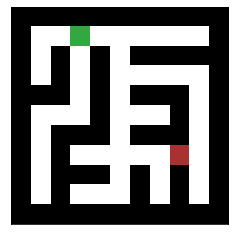

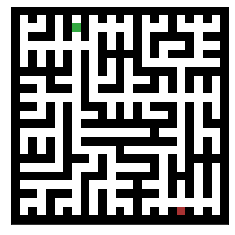

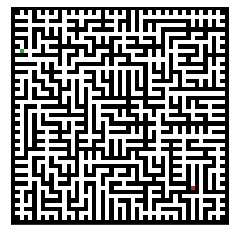

In [ ]:
for N, S, F in (11, (1, 3), (7, 8)), (25, (2, 7), (23, 19)), (51, (10, 2), (42, 42)):
    map = grid(N, S, F, 1)
    map.draw_map(S, F)

### Μέρος 2

---



#### Wrapper class για τη χρήση του builtin heapq κάνοντας override τη μέθοδο  `__lt__()`



In [ ]:
import heapq
class MyPoint:
  def __init__(self, val, f, g, parent=None):
    self.val = val
    self.f = f
    self.g = g
    self.parent = parent
 
  def __repr__(self): return str(self.val) # mainly for debugging purposes
 
  def __lt__(self,other):
    return self.f < other.f
 
  def coordinates(self): return self.val
 
class myMinHeap:
  def __init__(self):
    self.heap = []
    self.contains = set()
  
  def push(self,point):
    heapq.heappush(self.heap, point)
    self.contains.add(point.val)
 
  def pop(self):
    point_object = heapq.heappop(self.heap)
    self.contains.remove(point_object.val)
    return point_object
 
  def change(self,coords,f,g,parent):
    object_to_change = next((x for x in self.heap if x.val == coords), None)
    if object_to_change is None: print("e ntroph re malaka"); exit()
    object_to_change.f = f
    object_to_change.g = g
    object_to_change.parent = parent
    heapq.heapify(self.heap)
  
  def list(self):
    return list(self.contains)

  def is_empty(self):
    if self.heap: return False
    else: return True
  
  def __contains__(self,element):
    return (element in self.contains)

#### pathfinder class

In [ ]:
import heapq
class pathfinder:
    def __init__(self, S, F, grid, c, h):
        self.S = S
        self.F = F
        self.grid = grid
        self.cost = c
        self.heuristic = h
        self.vis = visualization(S, F)
        self.path=[]
 
    def retrace_path(self,current):
      self.path.append(current.val)
      while (current.parent):
        current = current.parent
        self.path.append(current.val)
 
 
    def find_path(self):
      frontier = myMinHeap()
      visited = {}      #key will be coordinates of a visited cell, value will be its so far lowest g() value
 
      frontier.push(MyPoint(self.S,self.heuristic(S),0))
      visited[self.S] = 0
 
      while (not frontier.is_empty()):
        current = frontier.pop()
        if current.val == self.F:
          self.retrace_path(current)
          self.vis.add_path(self.path)
          return len(visited)
        x,y = current.val
        all_neighbours = ((x+1,y), (x,y+1), (x,y-1), (x-1,y))
        in_bounds_neighbours = (i for i in all_neighbours if (i[0]>0 and i[1]>0 and i[0]<N-1 and i[1]<N-1))
        valid_neighbours = (i for i in in_bounds_neighbours if (self.grid.grid[i]!=1))
        for neighbour in valid_neighbours:
          g_from_current = current.g + self.cost(neighbour) # general form
          # g_from_current = 1 # this for convenietly testing the values 0 and 1
          if neighbour not in visited or g_from_current < visited[neighbour]:
            parent = current
            g = g_from_current
            f = g + self.heuristic(neighbour)
            visited[neighbour] = g            
            if neighbour not in frontier:
              frontier.push(MyPoint(neighbour,f,g,parent))
            else:
              frontier.change(neighbour,f,g,parent)
        self.vis.draw_step(self.grid,frontier.list(),list(visited))
      print("krima")
          
 
    def get_path(self):
        return self.path

#### Δοκιμές δεύτερου μέρους

In [ ]:
from math import sqrt


N = 70
S =  (1, 2)
F = (N-3, N-4)
def hammingDistance(n1, n2) : 
    x = n1 ^ n2  
    setBits = 0
    while (x > 0) : 
        setBits += x & 1
        x >>= 1
    return setBits
manhattan = lambda point: (abs(point[0] - F[0]) + abs(point[1] - F[1]))
euclidian = lambda point: (sqrt((point[0] - F[0])**2 + (point[1] - F[1])**2))
hamming = lambda point: hammingDistance(point[0],F[0]) + hammingDistance(point[1],F[1])

zero = lambda point: 0
one = lambda point: 1

map = grid(N, S, F, 1)
weight = lambda point: map.grid[point] 
 # changing the last parameter into any of the {euclidian,manhattan,hamming}
 # or the second last into any of the zero, one and weight we get the requested combinations
pf = pathfinder(S, F, map, weight, euclidian)
pf.find_path()
pf.vis.show_gif(fps = 1)

#### Ερωτήσεις δεύτερου μέρους


*   Με $g(n) = 0$ και $h(n) = \{manhattan(n),euclidian(n)\}$ προκύπτει ο αλγόριθμος Best First, ο οποίος βρίσκει πάντα λύση, αλλά όχι βελτιστη σίγουρα.
*   Με $g(n) = 1$ και $h(n) = 0$ προκύπτει Breadth First Search αλγόριθμος, αφού επιλέγεται κάθε φορά ο κόμβος με μικρότερη απόσταση απ'την αφετηρία $F$, ο οποίος βρίσκει πάντα τη βέλτιστη λύση (θεωρώντας ότι οι κόμβοι δεν έχουν βάρη ίδια προφανώς)
*   Με $g(n) = 1$ και $h(n) = \{manhattan(n),euclidian(n)\}$ προκύπτει ο A* ο οποίος βρίσκει πάντα λύση, αλλά βέλτιστη μόνο αν ο ευριστικός μηχανισμός είναι αποδεκτός (admissible), δηλαδή εδώ και για τις δύο $\{manhattan(n),euclidian(n)\}$ θα βρίσκει βέλτιστη λύση.

### Μέρος 3

---

#### Σημειώσεις

Χρειάστηκαν οι εξής αλλαγές:


*   Στην `grid.draw_map()` στο `image[self.grid == 0]` άλλαξε σε `image[self.grid >= 0]` (δε χρειάζεται αλλαγή στην επόμενη γραμμή γιατί έρχεται μετά και κάνει overwrite της αλλαγές αυτής).
*   Στην `pathfinder.find_path()` στο `(self.grid.grid[i]!=1)` χρειάστηκε προσαρμογή στη συνθήκη.
*   Στην `grid.__init__()` προστέθηκε ένα κομμάτι στο τέλος κι ένα έξτρα όρισμα με default τιμή None, που καθορίζει την επιλογή της κατανομής που ακολουθούν τα βάρη.
*   Στο `class visualization` χρειάστηκε αντίστοιχη αλλαγή με τη,πρώτη για τη σωστή δημιουργία των εικονών.
*   Στο `pathfinder.find_path()` χρειάστηκε να αλλάξει το τι επιστρέφει από `None` σε `len(visited)` για να μπορώ να ανακτήσω το πλήθος των κόμβων που επεκτείνονται.
*   Στο `grid` χρειάστηκε διόρθωση στο κομμάτι που κάνει σίγουρη την ύπαρξη ενός μονοπατιού. Συγκεκριμένα `obstacle_free_points={S}` και προσθήκη του στόχου στο τέλος, έτσι ή θα είναι σε ένα κελί ή θα 'σπάσει' τοίχο και `if (point in obstacle_free_points): return`

Οι παραπάνω αλλαγές έχουν ως αποτέλεσμα τη μη λειτουργία των απεικονίσεων του λαβυρίνθου στη περίπτωση που δε δοθεί κάποια κατανομή στη κατασκευή του που να παίρνει τιμές από (0,1) exclusive

#### Σχεδιασμός γραφικών παραστάσεων

Δίνονται γραφικές παραστάσεις:
* για τρία εύρη τιμών της κατανομής,
* για κάθε μια εκ των τριών κατανομών που επιλέχθηκαν, 
* για μεγέθη πίνακα από $8$ ως $50$ (το τρέξαμε και με μεγαλύτερες τιμές ($8$ ως $100$ ανά $2$) και παρατίθονται οι μεγαλύτερες τιμές, αλλά για να μην πάρει πολύ ώρα στον κώδικα δίνουμε αυτές) 
* για κάθε μια εκ των τριών ευριστικών που επιλέχθηκαν

Παρατίθενται ομαδοποιημένες για ευκολία.

---------------------------------------------------------------------------------
Distributions in range x=0.0, y=0.1


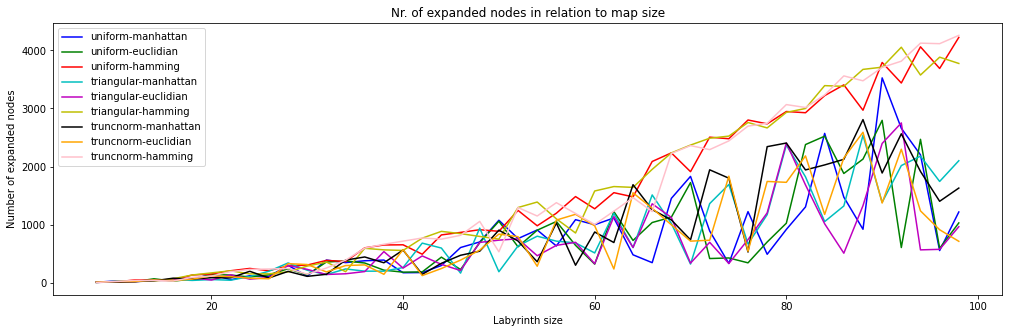

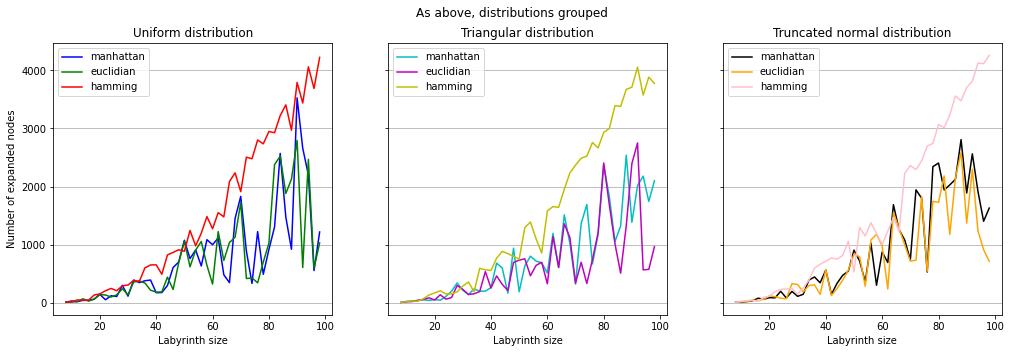

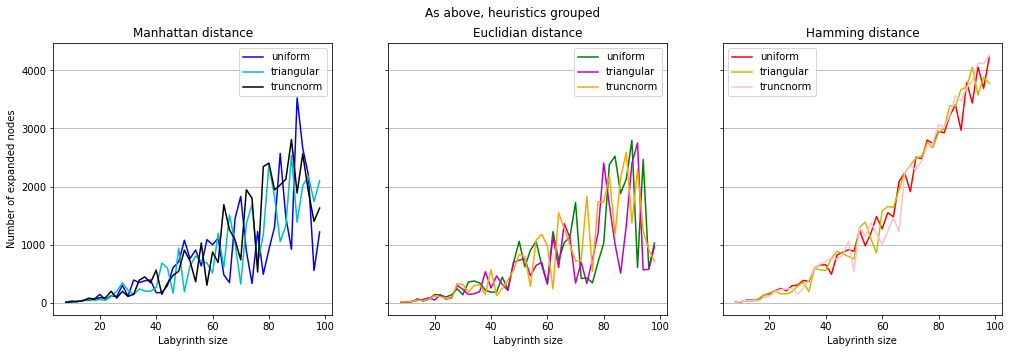

---------------------------------------------------------------------------------
Distributions in range x=0, y=1


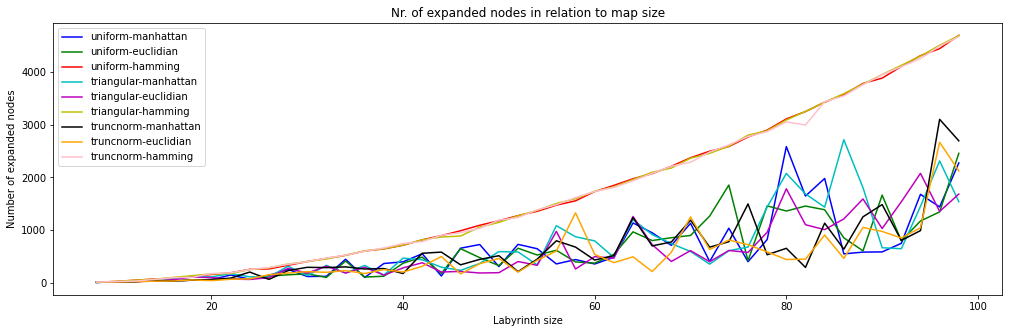

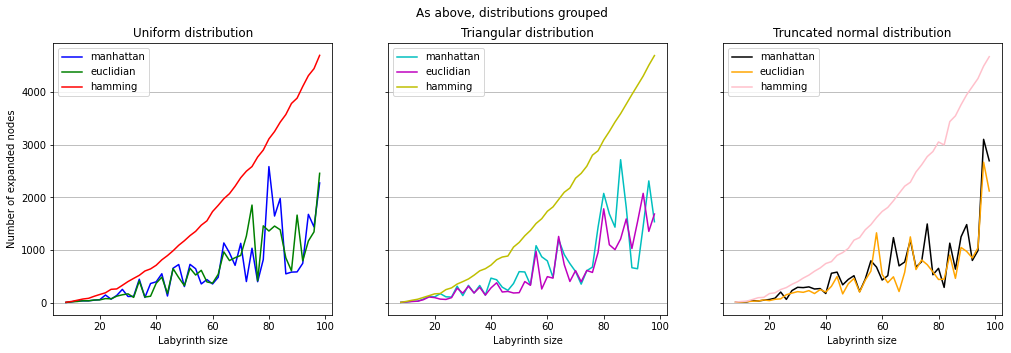

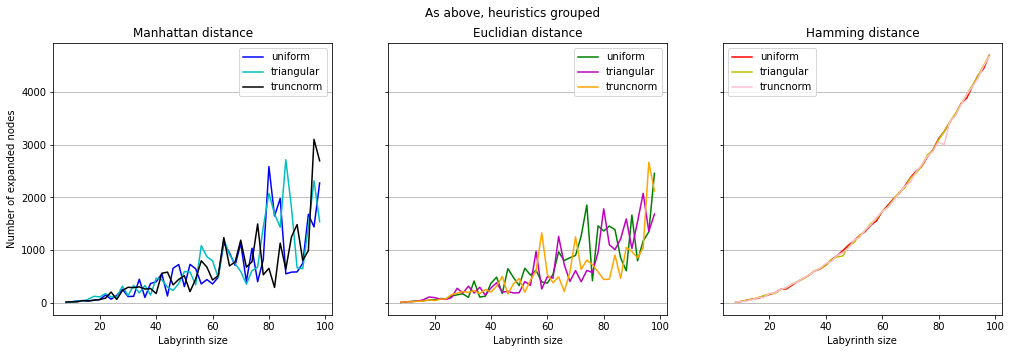

---------------------------------------------------------------------------------
Distributions in range x=1, y=2


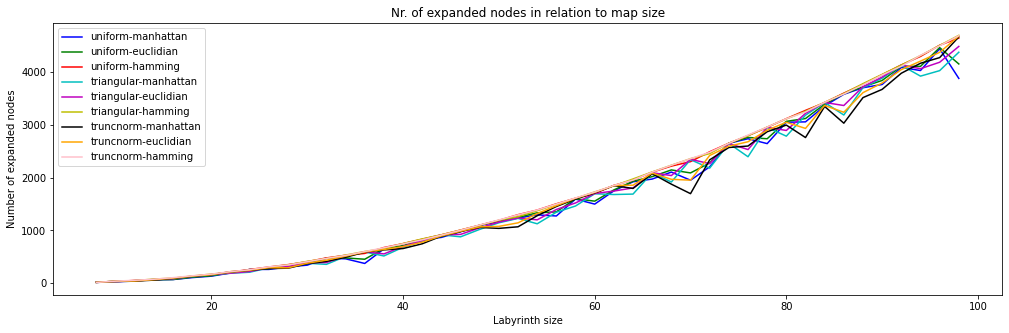

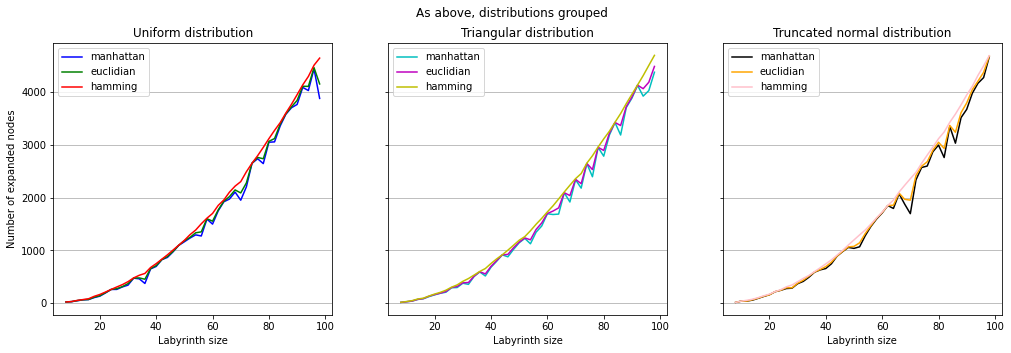

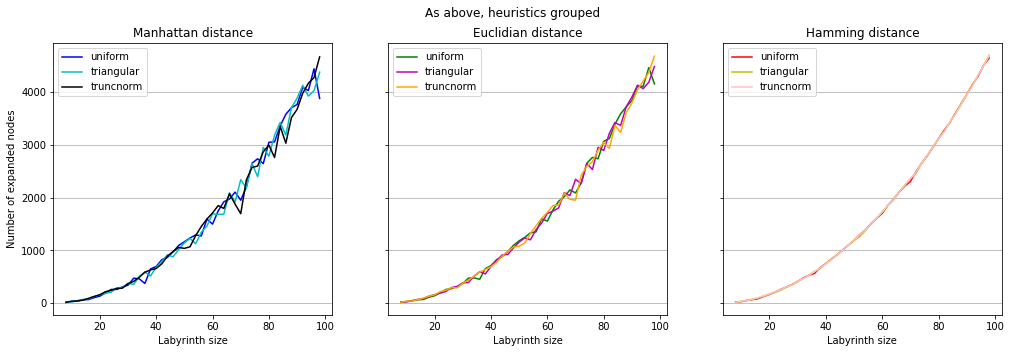

In [ ]:
from math import sqrt
import matplotlib.pyplot as plt

# setup
def hammingDistance(n1, n2) :   
    x = n1 ^ n2  
    setBits = 0
    while (x > 0) : 
        setBits += x & 1
        x >>= 1
    return setBits
for (giorgos,kwstas) in ((0.0,0.1), (0,1), (1,2)):
  print("---------------------------------------------------------------------------------")
  print("Distributions in range x="+str(giorgos)+", y="+str(kwstas))
  distrDict = {"uniform":1, "triangular":2, "truncnorm":3}
  heuristics = ("manhattan", "euclidian", "hamming")
  uniRes = {heurist:[] for heurist in heuristics}
  trianRes = {heurist:[] for heurist in heuristics}
  normRes = {heurist:[] for heurist in heuristics}
  results = {"uniform":uniRes, "triangular":trianRes, "truncnorm":normRes}
  sizes = [*range(8,51)]  ### Isws na to meiwsoume auto na moiasoun pio omorfa ?

  # path finding
  for distribution in distrDict:  
    for N in sizes:
      S = (1,2)
      F = (N-3,N-4)
      # print(N)
      manhattan = lambda point: (abs(point[0] - F[0]) + abs(point[1] - F[1]))
      euclidian = lambda point: (sqrt((point[0] - F[0])**2 + (point[1] - F[1])**2))
      hamming = lambda point: hammingDistance(point[0],F[0]) + hammingDistance(point[1],F[1]) 
      heuristDict = {"manhattan":manhattan, "euclidian":euclidian, "hamming":hamming}

      labyrinth = grid(N,S,F,distrDict[distribution],giorgos,kwstas)
      weight = lambda point: labyrinth.grid[point]
      
      for heuristic in heuristDict:
        pf = pathfinder(S,F,labyrinth,weight,heuristDict[heuristic])
        # print(S,F,distribution,heuristic,heuristDict[heuristic])
        temp = pf.find_path()
        results[distribution][heuristic].append(temp)     
  # plotting
  colors = (i for i in ("b","g","r","c","m","y","k","#ffa500","#ffc0cb"))
  plt.figure(figsize=(17,5))
  for distr in results:
    for heur in results[distr]:
      plt.plot(sizes, results[distr][heur], next(colors), label=distr+"-"+heur)
  plt.title("Nr. of expanded nodes in relation to map size")
  plt.ylabel("Number of expanded nodes")
  plt.xlabel("Labyrinth size")
  plt.legend()
  ########################
  colors = (i for i in ("b","g","r","c","m","y","k","#ffa500","#ffc0cb"))
  fig1, (fig1_1, fig1_2, fig1_3) = plt.subplots(1,3, sharey=True)
  fig1.suptitle("As above, distributions grouped")
  fig1.set_figheight(5)
  fig1.set_figwidth(17)
  for heur in results['uniform']:
    fig1_1.plot(sizes, results['uniform'][heur], next(colors), label=heur)
  fig1_1.set_title("Uniform distribution")
  for heur in results['triangular']:
    fig1_2.plot(sizes, results['triangular'][heur], next(colors), label=heur)
  fig1_2.set_title("Triangular distribution")
  for heur in results['truncnorm']:
    fig1_3.plot(sizes, results['truncnorm'][heur], next(colors), label=heur)
  fig1_3.set_title("Truncated normal distribution")

  for i in (fig1_1, fig1_2, fig1_3):
    i.set(xlabel="Labyrinth size")
    i.legend()
    i.grid(axis='y') ### This enables the grids
  fig1_1.set(ylabel="Number of expanded nodes")

  ########################
  colors = (i for i in ("b","c","k","g","m","#ffa500","r","y","#ffc0cb"))
  fig2, (fig2_1, fig2_2, fig2_3) = plt.subplots(1,3, sharey=True)
  fig2.suptitle("As above, heuristics grouped")
  fig2.set_figheight(5)
  fig2.set_figwidth(17)
  for distr in results:
    fig2_1.plot(sizes, results[distr]["manhattan"], next(colors), label=distr)
  fig2_1.set_title("Manhattan distance")
  for distr in results:
    fig2_2.plot(sizes, results[distr]["euclidian"], next(colors), label=distr)
  fig2_2.set_title("Euclidian distance")
  for distr in results:
    fig2_3.plot(sizes, results[distr]["hamming"], next(colors), label=distr)
  fig2_3.set_title("Hamming distance")

  for i in (fig2_1, fig2_2, fig2_3):
    i.set(xlabel="Labyrinth size")
    i.legend()
    i.grid(axis='y')  ### This enables the grids
  fig2_1.set(ylabel="Number of expanded nodes")
  plt.show()

#### Ερωτήσεις τρίτου μέρους

Παρατηρούμε γενικά ότι η η χρήση της hamming distance ως ευριστικής είναι λιγότερο αποδοτική, λογικό αφού δεν απεικονίζει κάποια σημαντική πληροφορία που έχουμε για την απόσταση ενός σημείου από το στόχο $F$. 

Όσον αφορά τις περιπτώσεις που οι κατανομή των βαρών παίρνει τιμές στα εύρη $(0.0, 0.1)$ και $(1,2)$. Παρατηρούμε ότι στην πρώτη περίπτωση υπάρχει μεγαλύτερος βαθμός τυχαιότητας στο πλήθος των επεκταμένων κόμβων. Στη δεύτερη περίπτωση η επιλογή ευριστικής συνάρτησης παίζει λιγότερο σημαντικό ρόλο, πράγμα αρκετά λογικό αφού στην συνάρτηση $f(n)$ την οποία χρησιμοποιεί ο $A*$ για να αποφασίζει θα έχει μεγαλύτερη επίδραση το βάρος μετακίνησης μεταξύ των κόμβων